# Overview

#### This analysis came after the Exploratory Data Analysis in this dataset (Vidio_Rodzan_question_2.ipynb). In this notebook I analyzed some features (columns) that have the biggest impact to the 'is_premium' column whether the users is premium  or non premium using one of most popular algorithm, Random Forest Classifier. The result shows whether the vidio content is interesting, boring, good rating or bad rating and advertisement in Vidio player determines the user will premium or not, it shows by 'title' and 'has_ad' as top 2 of feature importances in Random Forest Classifier algorithm.

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Read the clean dataset

In [3]:
df = pd.read_csv('10% sample data cleaned.csv')

# Feature Engineering

###### Drop the unnecessary and too specific features

In [4]:
df.drop(['hash_content_id', 'hash_play_id', 'hash_visit_id', 'hash_watcher_id',
         'hash_film_id', 'hash_event_id', 'referrer'], inplace=True, axis=1)

###### Transform date columns to datetime format and extract hour and day of week as new feature

In [5]:
date_columns = ['play_time', 'end_time']
for col in date_columns:
    df[col] = pd.to_datetime(df[col]).dt.tz_localize(None)
df['play_time_dayofweek'] = df['play_time'].dt.dayofweek
df['play_time_hour'] = df['play_time'].dt.hour

In [6]:
date_time_columns = ['play_time', 'end_time', 'date_play', 'day_names_play', 'hour_play']
df.drop(date_time_columns, axis=1, inplace=True)

###### Transform boolean data type to object

In [7]:
bool_columns = [col for col in df.columns if df[col].dtypes == 'bool']
for col in bool_columns:
    df[col] = df[col].astype(str)

###### Fill nan data in 'average_bitrate' feature with 'average_bitrate' mean

In [8]:
mean_value = df['average_bitrate'].mean()
df['average_bitrate'].fillna(mean_value, inplace=True)

###### Define numeric and categorical columns

In [9]:
num_columns = [col for col in df.columns if df[col].dtypes != "O"]

In [10]:
cat_columns = [col for col in df.columns if col not in num_columns]

###### Transform True False 'is_premium' to numeric value (0 and 1)

In [11]:
premium_num = {'False':0, 'True':1}
df['is_premium'] = df['is_premium'].map(premium_num)

###### Transform categorical columns to numeric based on sum of the categorical data towards 'is_premium'

In [12]:
def encode_category(data, column, target):
    ordinal_data= data.groupby([column])[target].sum().sort_values(ascending=False).index
    ordinal_num = {k: i for i, k in enumerate(ordinal_data, start=0)}
    data[column] = data[column].map(ordinal_num)
    print(ordinal_data)

In [13]:
for col in cat_columns:
    encode_category(df, col, 'is_premium')

Index(['True', 'False'], dtype='object', name='is_login')
Index(['direct', 'embed'], dtype='object', name='playback_location')
Index(['app-android', 'tv-android', 'tv-tizen', 'app-ios', 'web-desktop',
       'web-mobile', 'tv-webos'],
      dtype='object', name='platform')
Index(['200-500', '0-200', 'unknown'], dtype='object', name='bitrate_range')
Index(['others', 'empty', 'internal', 'telkomsel', 'twitter', 'otosia',
       'merdeka', 'liputan6', 'kapanlagi', 'google', 'fimela', 'facebook',
       'emtek', 'dream', 'bolanet', 'bola'],
      dtype='object', name='referrer_group')
Index(['False', 'True'], dtype='object', name='completed')
Index(['unknown', 'vod', 'partnership', 'marketing', 'livestreaming', 'avod',
       'Youtube', 'HDLN', 'FB'],
      dtype='object', name='utm_source')
Index(['unknown', 'telco_smartfren', 'referrer', 'post', 'paid', 'app-android',
       'Post'],
      dtype='object', name='utm_medium')
Index(['unknown', 'vidio-share?utm_source=marketing', 'vidio-sha

###### Normalize the dataset, so it will in the same range

In [14]:
from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler()
columns_training = [column for column in df.columns if column not in ['is_premium']]
df[columns_training] = sc_X.fit_transform(df[columns_training])

###### Check and filter multi collinearity between features

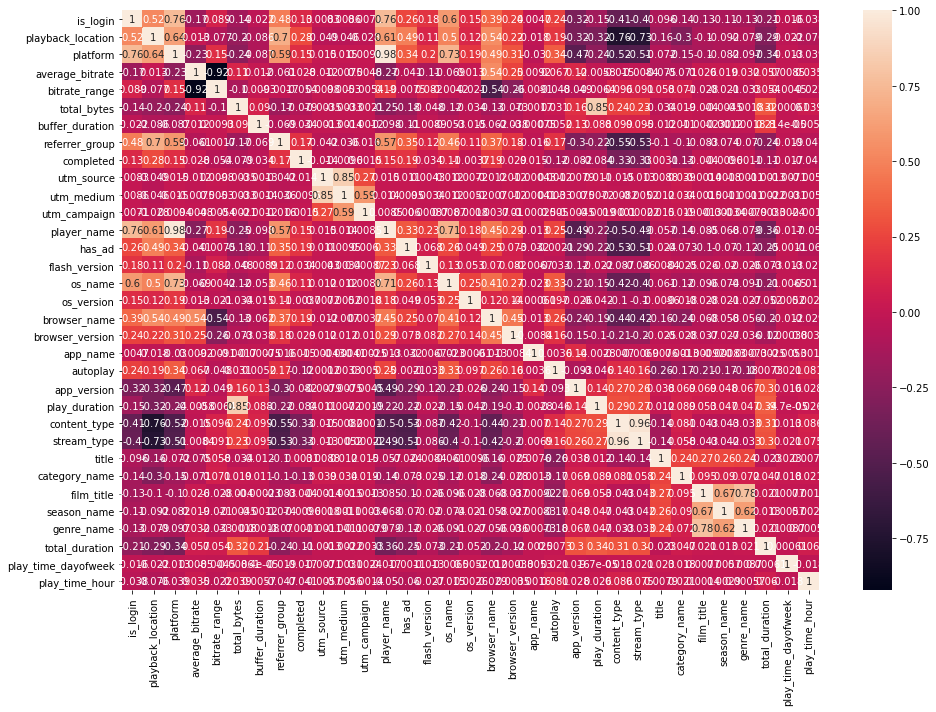

In [15]:
columns_training = [column for column in df.columns if column not in ['is_premium']]
plt.figure(figsize=(14,10))
sns.heatmap(df[columns_training].corr(), annot=True)
plt.tight_layout()

In [16]:
multicollinearity_columns = ['player_name', 'bitrate_range', 'total_bytes', 'utm_medium', 'stream_type', 'season_name', 'film_title']
df.drop(multicollinearity_columns, inplace=True, axis=1)

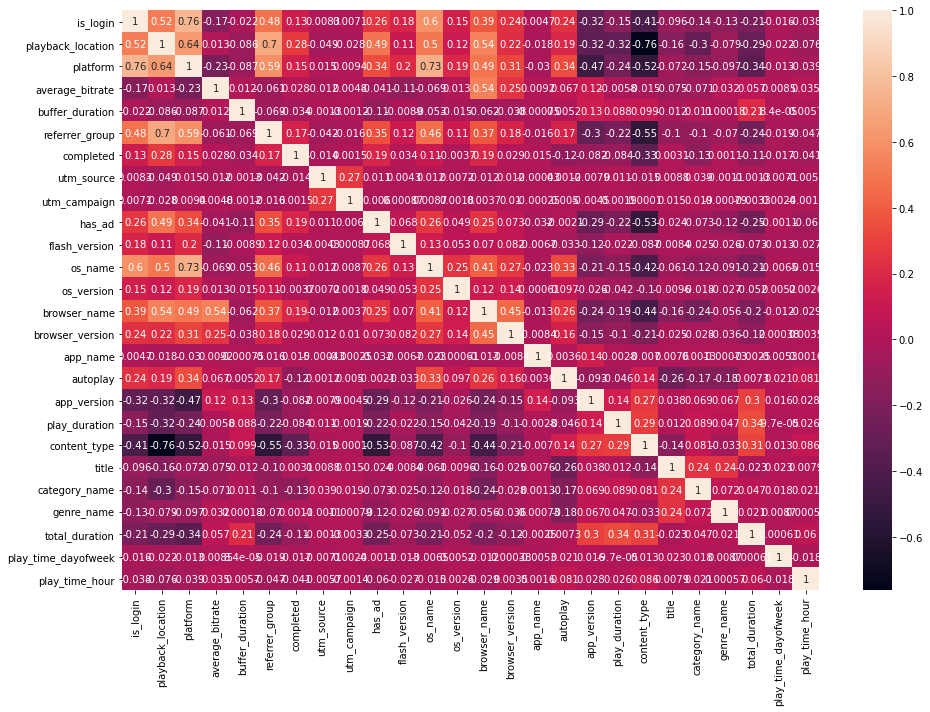

In [17]:
columns_training = [column for column in df.columns if column not in ['is_premium']]
plt.figure(figsize=(14,10))
sns.heatmap(df[columns_training].corr(), annot=True)
plt.tight_layout()

###### Define features data and target data as X and y

In [18]:
columns_training = [column for column in df.columns if column not in ['is_premium']]
y = df['is_premium']
X = df[columns_training]

###### Imbalance check between premium and non premium data in dataset

In [19]:
y.value_counts()

1    240489
0      1309
Name: is_premium, dtype: int64

###### Resamping data using Synthetic Minority Oversampling Technique (SMOTE)

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts()

1    240489
0    240489
Name: is_premium, dtype: int64

###### Split the dataset to train and test data

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, random_state=41, test_size=0.2)

In [30]:
y_train.value_counts()

1    192440
0    192342
Name: is_premium, dtype: int64

# Machine Learning Model

In [31]:
def model_selection(X_train, y_train, X_test, y_test, models):
    
    from sklearn.metrics import accuracy_score, f1_score
    
    accuracy_result = []
    f1_result = []
    str_models = []
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)       
        accuracy_result.append(accuracy)
        f1_result.append(f1)  
        str_models.append(str(model))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

    ax1.plot(accuracy_result)
    ax1.set_ylabel('accuracy_score')

    ax2.plot(str_models,f1_result)
    ax2.set_ylabel('f1_result')
    ax2.set_xticklabels(str_models, rotation=90)
    plt.tight_layout()
    
    return pd.DataFrame({'models':models, 'accuracy':accuracy_result, 'f1':f1_result}) 

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

,models,accuracy,f1
0,LogisticRegression(),0.998451,0.998448
1,"(DecisionTreeClassifier(max_features='auto', r...",0.999969,0.999969


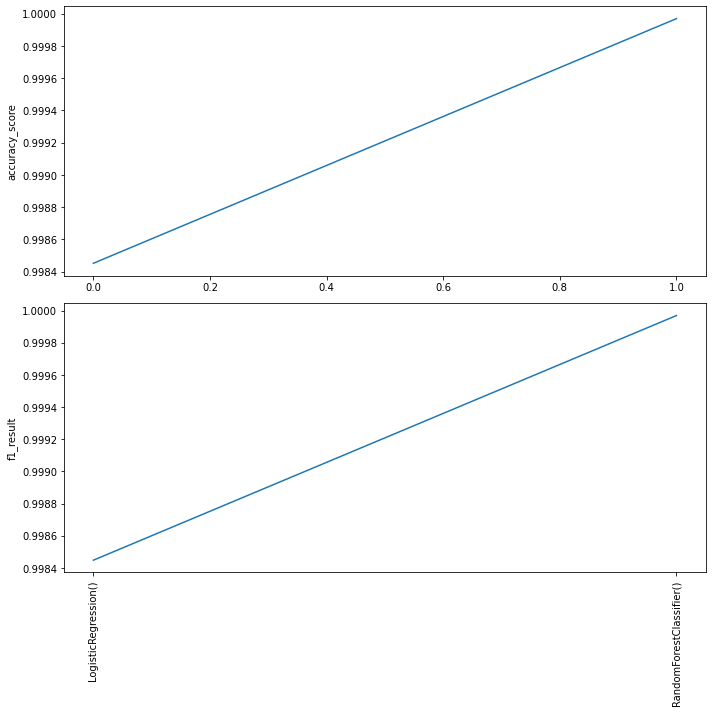

In [33]:
models = [LogisticRegression(), RandomForestClassifier()]

model_selection(X_train, y_train, X_test, y_test, models)

In [38]:
def confusion(X_train, y_train, X_test, y_test, model):
    from sklearn.metrics import confusion_matrix
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    confu_score = confusion_matrix(y_pred, y_test, labels=[1,0])
    return pd.DataFrame(confu_score, columns=['Actual Postive', 'Actual Negative'], 
                        index=['Predicted Positive', 'Predicted Negative'])

In [39]:
rf = RandomForestClassifier()

confusion(X_train, y_train, X_test, y_test, rf)

,Actual Postive,Actual Negative
Predicted Positive,48046,0
Predicted Negative,3,48147


In [34]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

# Feature Importances

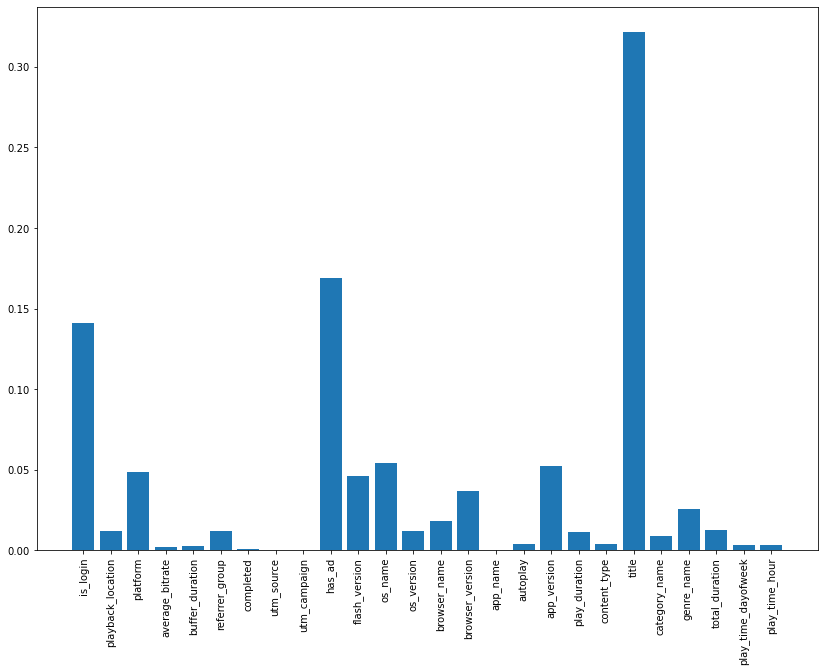

In [37]:
importance = rf.feature_importances_

plt.figure(figsize=(14,10))
plt.bar([y for y in X_train.columns],importance)
plt.xticks(rotation=90)
plt.show()

## Feature Importances result

### The Feature Importances shows that title and has_ad as the 2 top biggest impact to user will be premium or not. So with this information, marketing team, developer team and another related team can approaching the user to get more premium user by improving the quality of the content, variance topics of the content etc by using further analysis information on the content of Vidio.com.  